# Description: 
This notebook contains the process of making a simulated dataset and training and evaluating a functional encoder using the generated dataset using the Pairwise Siamese Contrastive (PSC) method

# Import Libraries 

## General libraries

In [1]:
from torch.utils.data import DataLoader
import plotly.io as pio
import pickle


## Local libraries

In [2]:
from src.tools.simulation import *
from src.models.CNN_encoder import *
from src.signal.signal_processing import *
from src.pipelines.embedding_data_preparation import *
from src.utils.utils import *
from src.training.PSC_training import *
from src.training.visualize_embedding import *
from src.training.evaluation import *

# Create synthetic example signals from each region

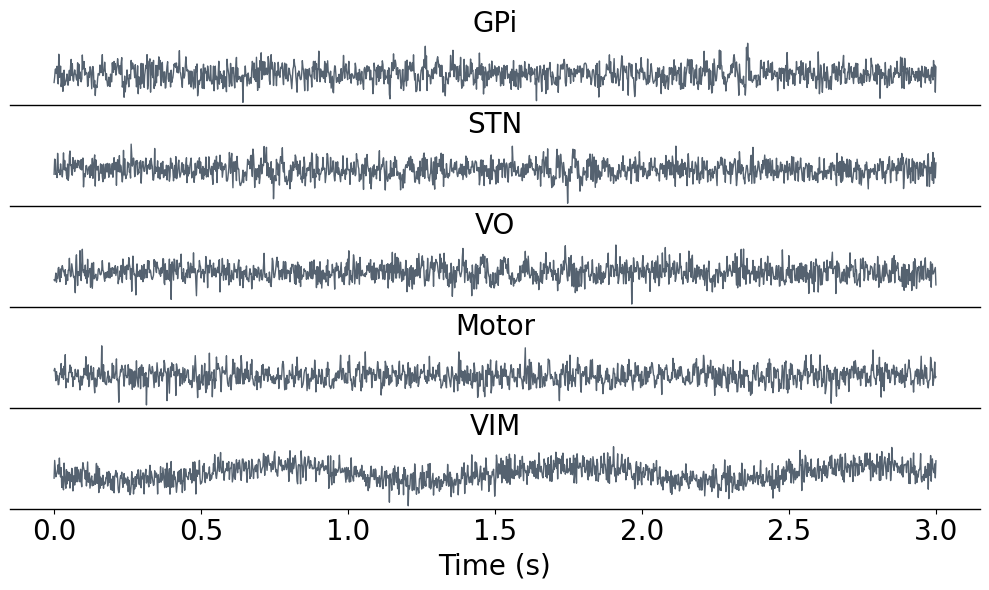

In [3]:
fs = 500
duration = 3
t = np.linspace(0, duration, int(fs * duration))
subject_params = {
    "beta_gain": 1.2, "beta_freq_offset": 0, "beta_burst_prob": 0.5,
    "spindle_gain": 1.0, "spindle_freq_offset": 0, "spindle_burst_prob": 0.5,
    "gamma_gain": 0.5, "gamma_freq_offset": 0,
    "hfo_gain": 0.2, "hfo_freq_offset": 0,
    "slow_gain": 1.0, "slow_freq_offset": 0,
    "noise_level": 0.8
}
session_params = {"session_noise": 0.1}
electrode_params = [{"gain": 1.0, "electrode_noise": 0.05} for _ in range(1)]

# Generate examples
examples = {
    "GPi": generate_gpi_signal(subject_params, session_params, electrode_params, duration, fs, 1)[0],
    "STN": generate_stn_signal(subject_params, session_params, electrode_params, duration, fs, 1)[0],
    "VO": generate_vo_signal(subject_params, session_params, electrode_params, duration, fs, 1)[0],
    "Motor": generate_motor_signal(subject_params, session_params, electrode_params, duration, fs, 1)[0],
    "VIM": generate_vim_signal(subject_params, session_params, electrode_params, duration, fs, 1)[0]
}

# Plot minimal version
plt.figure(figsize=(10, 6))
for i, (region, signal) in enumerate(examples.items()):
    ax = plt.subplot(len(examples), 1, i + 1)
    ax.plot(t, signal, linewidth=1.0, color="#556270")

    ax.set_title(f"{region}", fontsize=20, loc="center")
    ax.set_ylabel("Amp.", fontsize=18)

    if i < len(examples) - 1:
        ax.set_xticks([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Time (s)", fontsize=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    # removes y axis
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.spines['left'].set_visible(False)

    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20 if i == len(examples) - 1 else 0)

plt.tight_layout(h_pad=0.4)
plt.show()


psd_data = {}
for region, signal in examples.items():
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    psd_data[region] = (f, Pxx)

# Create Plotly figure
fig = go.Figure()
for region, (f, Pxx) in psd_data.items():
    fig.add_trace(go.Scatter(x=f, y=10 * np.log10(Pxx), mode='lines', name=region))

fig.update_layout(
    title="Power Spectral Density of Simulated Region Signals",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Power Spectral Density (dB/Hz)",
    template="plotly_white",
    legend=dict(title="Region")
)
fig.show()

# Simulating a full dataset consisting of 10 subjetcs, 2 sessions per subject

In [ ]:
# Run dataset simulation with all 5 regions
data_dir = "data/raw_simulated_dataset_noise_0_3"
full_metadata = simulate_full_dataset(regions=["GPi", "STN", "VO", "Motor", "VIM"], duration=1000, fs=1000, output_dir=data_dir, n_subjects=10)

creating the dataset for: Subject 0
creating the dataset for: Subject 1
creating the dataset for: Subject 2
creating the dataset for: Subject 3
creating the dataset for: Subject 4
creating the dataset for: Subject 5
creating the dataset for: Subject 6
creating the dataset for: Subject 7
creating the dataset for: Subject 8
creating the dataset for: Subject 9


# Use simulation data to train a functional encoder 

## Step1: window and preprocess data for training functional embedding

In [ ]:
SEGMENT_LENGTH = 10000  # windows for CNN in ms (input 10 seconds here)
fs = 1000 
# Define held-out subject(s)
held_out_subjects = ['subject_9']  

# Initialize pooled dictionaries
training_segments_dict = {}
validation_segments_dict = {}
testing_segments_dict = {}
heldout_segments_dict = {}
for subject_folder in sorted(os.listdir(data_dir)):
    subject_path = os.path.join(data_dir, subject_folder)
    if not os.path.isdir(subject_path):
        continue
    is_held_out = subject_folder in held_out_subjects
    
    for file in sorted(os.listdir(subject_path)):
        if not file.endswith(".npz"):
            continue
        session_data = np.load(os.path.join(subject_path, file))
        session_name = file
        print(f"\nLoading {subject_folder} {session_name} (held out: {is_held_out})")
        for region, signal in session_data.items():
            for ch in signal:

                # Remove big 60Hz artifacts
                filtered_signal = notch_filter(ch, fs)

                # Normalize session recording
                normalized_signal = normalize_signal(filtered_signal)

                # Apply notch filters at 60Hz and its harmonics
                normalized_signal = notch_filter(normalized_signal, fs, freq=60)
                normalized_signal = notch_filter(normalized_signal, fs, freq=120)
                normalized_signal = notch_filter(normalized_signal, fs, freq=180)

                # Segment data into windows
                segments = segment_data(normalized_signal, SEGMENT_LENGTH)
                
                # Split segments into training, validation, and testing sets
                num_val = int(0.15 * len(segments))
                num_test = int(0.15 * len(segments))
                val_segments = segments[:num_val]
                test_segments = segments[num_val:num_val+num_test]
                train_segments = segments[num_val+num_test:]

                # Add segments to appropriate dictionary
                if is_held_out:
                        heldout_segments_dict.setdefault(region, []).extend(segments)
                else:
                    training_segments_dict.setdefault(region, []).extend(train_segments)
                    validation_segments_dict.setdefault(region, []).extend(val_segments)
                    testing_segments_dict.setdefault(region, []).extend(test_segments)
                


Loading subject_0 session_0.npz (held out: False)
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments before cleaning: 100 | After cleaning: 100
Segments befo

### Save segments 

In [6]:
# Save segment dictionaries
save_dir = os.path.join("data", "preprocessed_simulated_dataset_noise_0_3")
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, "training_segments.pkl"), "wb") as f:
    pickle.dump(training_segments_dict, f)
with open(os.path.join(save_dir, "validation_segments.pkl"), "wb") as f:
    pickle.dump(validation_segments_dict, f)
with open(os.path.join(save_dir, "testing_segments.pkl"), "wb") as f:
    pickle.dump(testing_segments_dict, f)
with open(os.path.join(save_dir, "heldout_segments.pkl"), "wb") as f:
    pickle.dump(heldout_segments_dict, f)

### Load segments

In [7]:
# Load segment dictionaries
load_dir = os.path.join("data", "preprocessed_simulated_dataset_noise_0_3")
with open(os.path.join(load_dir, "training_segments.pkl"), "rb") as f:
    training_segments_dict = pickle.load(f)
with open(os.path.join(load_dir, "validation_segments.pkl"), "rb") as f:
    validation_segments_dict = pickle.load(f)
with open(os.path.join(load_dir, "testing_segments.pkl"), "rb") as f:
    testing_segments_dict = pickle.load(f)
with open(os.path.join(load_dir, "heldout_segments.pkl"), "rb") as f:
    heldout_segments_dict = pickle.load(f)

## Step2: Train the CNN encder with generated dataset

In [ ]:
# ----------- Config ------------
# data preparation 
SEGMENT_LENGTH = 10000 # in ms in this case 10 seconds

# training paramters
BATCH_SIZE = 1024
LEARNING_RATE = 1e-2
EPOCHS = 20
DATASET_SIZE = 100000

# model paramters: 
EMBEDDING_DIM = 32
EXPERIMENT = "simulation_noise_0_3"

# Check GPU
device = get_device()
print(f" Using {device}")
# -------------------------------

# Shuffle segments within each region key before training
print("Shuffle segments...")
for d in [training_segments_dict, validation_segments_dict, testing_segments_dict, heldout_segments_dict]:
    for k in d:
        np.random.shuffle(d[k])

# Generate training and validation pairs for the Pairwise Siamese Contrastive (PSC) method
print("Generating training and validation pairs...")
train_pairs, train_labels = create_balanced_pairs(training_segments_dict, DATASET_SIZE)
val_pairs, val_labels = create_balanced_pairs(validation_segments_dict, int(0.2 * DATASET_SIZE))


# Create DataLoaders
train_ds = LFPDataset(train_pairs, train_labels)
val_ds = LFPDataset(val_pairs, val_labels)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

# Train model
print("Training model...")
model = SiameseNetSingleSubject(embedding_dim=32, dropout=0.3).to(device)

print_model_summary(model, train_loader, device)
run_name = create_timestamped_logdir(prefix= EXPERIMENT + "Multi_Subject_")
trained_model = training_validate_loop(model, train_loader, val_loader, device, run_name, EPOCHS, LEARNING_RATE)

 Using cuda
Shuffle segments...
Generating training and validation pairs...
Created 100000 total pairs (50000 similar, 50000 dissimilar) from 5 regions.
Created 20000 total pairs (10000 similar, 10000 dissimilar) from 5 regions.
Training model...
===== Sample Forward Pass Shape Info =====

Model Summary:

SiameseNetSingleSubject(
  (encoder): CNNEncoderSingleSubject(
    (layers): ModuleList(
      (0): Conv1d(1, 64, kernel_size=(15,), stride=(4,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
      (5): Conv1d(64, 64, kernel_size=(11,), stride=(2,))
      (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): GELU(approximate='none')
      (8): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Dropout(p=0

## Step 3: Evaluate the functional encoder

In [9]:

# Extract encoder and evaluate
encoder_model = trained_model.encoder.eval()

# Extract embeddings
print("Extracting embeddings...")
train_emb, train_labels_text = embed_segments_dict(training_segments_dict, encoder_model, device)
val_emb, val_labels_text = embed_segments_dict(validation_segments_dict, encoder_model, device)
test_emb, test_labels_text = embed_segments_dict(testing_segments_dict, encoder_model, device)
held_emb, held_labels_text = embed_segments_dict(heldout_segments_dict, encoder_model, device)

# KNN Evaluation
print("Extracting embeddings...")
results_train = evaluate_knn(train_emb, train_labels_text, train_emb, train_labels_text)
results_val = evaluate_knn(train_emb, train_labels_text, val_emb, val_labels_text)
results_test = evaluate_knn(train_emb, train_labels_text, test_emb, test_labels_text)
results_held = evaluate_knn(train_emb, train_labels_text, held_emb, held_labels_text)

# Chance & clustering
print ("Computing clustering metrics...")
chance_train = compute_chance_levels(train_labels_text)
chance_val = compute_chance_levels(val_labels_text)
chance_test = compute_chance_levels(test_labels_text)
chance_held = compute_chance_levels(held_labels_text)

metrics_train = evaluate_clustering_metrics(train_emb, train_labels_text)
metrics_val = evaluate_clustering_metrics(val_emb, val_labels_text)
metrics_test = evaluate_clustering_metrics(test_emb, test_labels_text)
metrics_held = evaluate_clustering_metrics(held_emb, held_labels_text)

# Confusion matrices
print("Generating and saving confusion matrices...")
save_path = os.path.join("results", EXPERIMENT)
os.makedirs(save_path, exist_ok=True)
plot_and_save_confusion_matrix(val_labels_text, results_val['predictions'], sorted(set(val_labels_text)), "Validation Confusion", os.path.join(save_path, "cm_val.png"))
plot_and_save_confusion_matrix(test_labels_text, results_test['predictions'], sorted(set(test_labels_text)), "Test Confusion", os.path.join(save_path, "cm_test.png"))
plot_and_save_confusion_matrix(held_labels_text, results_held['predictions'], sorted(set(held_labels_text)), "Held-Out Subject Confusion", os.path.join(save_path, "cm_heldout.png"))

# Embedding visualization (test only)
test_region_list = [label for label in test_labels_text]
test_side_list = ["" for _ in test_labels_text]
test_electrode_list = [""] * len(test_labels_text)
fig,_ = plot_interactive_embeddings(test_emb, test_region_list, test_electrode_list, test_side_list, dim=2, method='pca', metric='euclidean', show_ellipses=True)
pio.write_image(fig, os.path.join(save_path, f"embedding_testset_pca_2D.png"), format="png", width=950, height=700)

# Save results
print("Saving evaluation summary...")
save_evaluation_to_excel(
    subject_id="Phase2_Multi_Subject_Training_" + EXPERIMENT,
    model_name=run_name,
    results_train=results_train,
    results_test=results_test,
    results_heldout=results_held,
    clustering_train=metrics_train,
    clustering_test=metrics_test,
    clustering_heldout=metrics_held,
    chance_train=chance_train,
    chance_test=chance_test,
    chance_heldout=chance_held,
    save_path=os.path.join(save_path, "evaluation_summary.xlsx")
)

Extracting embeddings...
Extracting embeddings...
Computing clustering metrics...
Generating and saving confusion matrices...
✅ Confusion matrix saved to: results\simulation_noise_0_3\cm_val.png
✅ Confusion matrix saved to: results\simulation_noise_0_3\cm_test.png
✅ Confusion matrix saved to: results\simulation_noise_0_3\cm_heldout.png


Saving evaluation summary...
✅ Evaluation saved to results\simulation_noise_0_3\evaluation_summary.xlsx


## Step 4: visualization of the functional Map

### Visualize heldout-subjects segments 

In [10]:

held_region_list = [label for label in held_labels_text]
held_side_list = ["" for _ in held_labels_text]
held_electrode_list = [""] * len(held_labels_text)
fig,_ = plot_interactive_embeddings(held_emb, held_region_list, held_electrode_list, held_side_list, dim=3, method='pca', metric='euclidean', show_ellipses=True, verbose=False)
# fig.update_layout(
#     legend=dict(x=1, y=0.7, xanchor='left', yanchor='top'),)
fig.show()  

### Visualize test segments 

In [11]:
test_region_list = [label for label in test_labels_text]
test_side_list = ["" for _ in test_labels_text]
test_electrode_list = [""] * len(test_labels_text)
fig,_ = plot_interactive_embeddings(test_emb, test_region_list, test_electrode_list, test_side_list, dim=2, method='pca', metric='euclidean', show_ellipses=True, verbose=False)
fig.update_layout(
    legend=dict(x=1, y=0.7, xanchor='left', yanchor='top'),
    font=dict( size=24, color="black")
)
fig.show()